In [21]:
import lightgbm as lgbm
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from skopt.space import Real, Integer
from scipy import sparse as ssp
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_data
from modelling import plot_estimators, tune_param

In [2]:
PATH_DATA = 'comments_processed.ft'

train_df, test_df = load_data(PATH_DATA, split=True, is_csv=False)

Let's split columns through types and apply a transformation to each, with encoding for categorical variables and scaling for numerical ones

In [3]:
drop_cols = ['subreddit', 'ups', 
             'link_id', 'id', 'name', 'body', 'author', 'parent_id',
             'subreddit_id']
categorical_cols = ['is_root', 'weekday', 'deleted', 'author_is_influential', 
                    'contains_url', 'contains_html', 'author_is_moderator', 'clusters']

numeric_cols = [col for col in train_df.select_dtypes(include=np.number).columns
                if col not in drop_cols and col not in categorical_cols]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_variables', numerical_transformer, numeric_cols),
        ('categorical_variables', categorical_transformer, categorical_cols)
    ])

In [4]:
estimators = [
    ('lgbm', lgbm.LGBMRegressor()),
    ('xgb', xgb.XGBRegressor())
]
pipe_all = Pipeline(steps=[('col_transfo', preprocessor)])
pipes = {}
for model in estimators:
    print('fitting...')
    pipe = Pipeline(steps=[('data_prep', pipe_all), model], verbose=True)
    pipe.fit(train_df.drop(columns='ups'), train_df.ups)
    pipes[pipe.steps[1][0]] = pipe

fitting...
[Pipeline] ......... (step 1 of 2) Processing data_prep, total=   4.4s
[Pipeline] .............. (step 2 of 2) Processing lgbm, total=   4.0s
fitting...
[Pipeline] ......... (step 1 of 2) Processing data_prep, total=   4.5s
[Pipeline] ............... (step 2 of 2) Processing xgb, total= 2.5min


Let's plot cross_validation results to see how models compare

CV on lgbm


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.5s finished


CV on xgb


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min finished


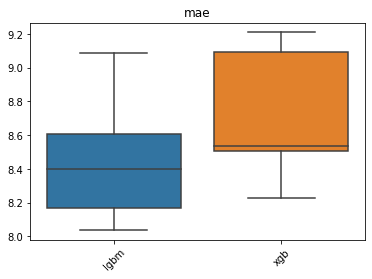

In [22]:
_metrics={'mae': make_scorer(mean_absolute_error)}
estimator_names=[model[0] for model in estimators]

plot_estimators(pipes=pipes, estimators=estimator_names, 
                n_splits=5, data=train_df.drop(columns='ups'), 
                target=train_df.ups, metrics=_metrics)

For the rest of the modelling, we will only keep the Lightboost part. So let's fine tune the model by using a Bayesian Search Cross validation from sklearn

In [12]:
param_grid = {'num_leaves': Integer(20, 100),
              'learning_rate': Real(1e-3, .3),
              'n_estimators': Integer(100, 1000),
              'subsample': Real(0.7, 1),
              'max_depth': Integer(3, 15),
              'min_child_weight': Real(0.01, 0.5),
              'min_split_gain': Real(0, 0.3),
              'feature_fraction': Real(0.7, 0.9)}

lgbcv, results = tune_param(model='lgbm',
                            pipes=pipes,
                            param_grid=param_grid,
                            refit=True,
                            data = train_df.drop(columns='ups'),
                            target=train_df.ups,
                            cv=5,
                            n_iter=20)
best_params = lgbcv.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


[Pipeline] ......... (step 1 of 2) Processing data_prep, total=   4.4s
[Pipeline] .............. (step 2 of 2) Processing lgbm, total=  10.5s
best score: -8.25260641613107
best params: OrderedDict([('lgbm__feature_fraction', 0.8195185734374574), ('lgbm__learning_rate', 0.06674786833218642), ('lgbm__max_depth', 10), ('lgbm__min_child_weight', 0.20874185467175646), ('lgbm__min_split_gain', 0.22636707243148557), ('lgbm__n_estimators', 233), ('lgbm__num_leaves', 99), ('lgbm__subsample', 0.969699780950025)])


NameError: name 'pd' is not defined

In [14]:
best_params =  {'lgbm__feature_fraction': 0.8195185734374574, 
                'lgbm__learning_rate': 0.06674786833218642, 
                'lgbm__max_depth': 10, 
                'lgbm__min_child_weight': 0.20874185467175646,
                'lgbm__min_split_gain': 0.22636707243148557, 
                'lgbm__n_estimators': 233,
                'lgbm__num_leaves': 99,
                'lgbm__subsample': 0.969699780950025}
best_params = {k[6:]: v for k,v in best_params.items()}

We will now use the best parameters to train our model and make predictions.
We will encode our categorical variables using OneHotEncoder, since the number of columns will be high we will sparse our dataset

In [16]:
Xx, yy = train_df.drop(columns=drop_cols), train_df.ups.values
XX_t = test_df.drop(columns=drop_cols)


print('Encoding...')
for c in categorical_cols:
    le = LabelEncoder()
    le.fit(Xx[c])
    Xx[c] = le.transform(Xx[c])

enc = OneHotEncoder()
enc.fit(train_df[categorical_cols])
X_cat = enc.transform(Xx[categorical_cols])
X_t_cat = enc.transform(XX_t[categorical_cols])
print('Encoding done...')

print('sparsing...')
train_list = [Xx.drop(columns=categorical_cols).values,X_cat,]
X = ssp.hstack(train_list).tocsr()
test_list = [XX_t.drop(columns=categorical_cols).values,X_t_cat,]
X_test = ssp.hstack(test_list).tocsr()
print('sparsing done...')

Encoding...
Encoding done...
sparsing...
sparsing done...


The last part is basically running a cross-validation on the train dataset and for each fold predicting our test set, and then taking the mean

In [19]:
NFOLDS = 5
N_ITER = 2
kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=420)
num_boost_round = 10000

final_cv_train = np.zeros(len(Xx))
final_cv_pred = np.zeros(len(test_df))

for s in range(N_ITER):
    cv_train = np.zeros(len(Xx))
    cv_pred = np.zeros(len(test_df))

    best_params['seed'] = s

    kf = kfold.split(train_df)

    best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):
        print(f"Fold number {i + 1} / {NFOLDS} on iteration {s + 1}")
        X_train, X_validate, label_train, label_validate = \
            X[train_fold, :], X[validate, :], yy[train_fold], yy[validate]
        dtrain = lgbm.Dataset(X_train, label_train)
        dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgbm.train(best_params, dtrain, num_boost_round, 
                         valid_sets=dvalid, verbose_eval=500,
                         early_stopping_rounds=100)
        best_trees.append(bst.best_iteration)
        cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)

        score = mean_absolute_error(label_validate, cv_train[validate])
        print("mae", score)
        fold_scores.append(score)
        
    cv_pred /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_pred

final_preds = final_cv_pred / N_ITER

Fold number 1 / 5 on iteration 1


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6892
[LightGBM] [Info] Number of data points in the train set: 2574809, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.84827
mae 7.848274036041041
Fold number 2 / 5 on iteration 1


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6872
[LightGBM] [Info] Number of data points in the train set: 2574809, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.8109
mae 7.810901499525997
Fold number 3 / 5 on iteration 1


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6877
[LightGBM] [Info] Number of data points in the train set: 2574810, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.69638
mae 7.696382448178506
Fold number 4 / 5 on iteration 1


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6910
[LightGBM] [Info] Number of data points in the train set: 2574810, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.5756
mae 7.575602831129641
Fold number 5 / 5 on iteration 1


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6880
[LightGBM] [Info] Number of data points in the train set: 2574810, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.67992
mae 7.679917393921936
Fold number 1 / 5 on iteration 2


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6860
[LightGBM] [Info] Number of data points in the train set: 2574809, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.85879
mae 7.858789709242043
Fold number 2 / 5 on iteration 2


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6869
[LightGBM] [Info] Number of data points in the train set: 2574809, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.84787
mae 7.847873605087671
Fold number 3 / 5 on iteration 2


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6907
[LightGBM] [Info] Number of data points in the train set: 2574810, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.69648
mae 7.6964767900519035
Fold number 4 / 5 on iteration 2


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6894
[LightGBM] [Info] Number of data points in the train set: 2574810, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.56561
mae 7.565608808584874
Fold number 5 / 5 on iteration 2


/home/othmane/anaconda3/envs/tf-38/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6903
[LightGBM] [Info] Number of data points in the train set: 2574810, number of used features: 64
[LightGBM] [Info] Start training from score 1.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	valid_0's l1: 7.70697
mae 7.706966346269478


In [22]:
subs = pd.DataFrame({'id': test_df.id, 'predicted': final_preds})
subs.to_csv('subs_lgbm.csv', index=False)